In [1]:
#import IPython;IPython.embed()
from model import mnist_2Layer # my model.py
from model import mnist_5Layer
from model import mnist_modified
from dataset import MNISTDataSet # my dataset.py
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from torch.nn.modules.loss import CrossEntropyLoss
from torch.optim import SGD
from torch.optim import Adam
import os
from torch.utils.data import DataLoader

[NbConvertApp] Converting notebook model.ipynb to script
[NbConvertApp] Writing 4370 bytes to model.py


In [2]:
OUTPUT_MODEL = "modelmodified"   # NAME OF FILE TO SAVE THE MODEL IN
cwd = os.getcwd()
print("CWD: ", cwd)
mnist_dataset_path = cwd + "/data/processed/training.pt"
print("Path to dataset: ", mnist_dataset_path)
model_checkpoint_save_path = cwd + "/" + OUTPUT_MODEL + "_checkpoints.pt"
print("Path to model checkpoints save file: ", model_checkpoint_save_path)
model_save_path = cwd + "/" + OUTPUT_MODEL + ".pt"
print("Path to model save file: ", model_save_path)

CWD:  /LAB2/Phase1
Path to dataset:  /LAB2/Phase1/data/processed/training.pt
Path to model checkpoints save file:  /LAB2/Phase1/modelmodified_checkpoints.pt
Path to model save file:  /LAB2/Phase1/modelmodified.pt


In [3]:
torch.cuda.init() #DELETE ME
USE_GPU = torch.cuda.is_available()
print("GPU AVAILABLE: ", USE_GPU)

GPU AVAILABLE:  True


In [4]:
BATCH_SIZE = 32
model = mnist_modified()  # MAKE SURE THE INSTANTIATE MODEL IS THE SAME AS THE FILE WHERE YOU SAVE THE WEIGHTS IN
if USE_GPU:
    model = model.cuda()  # Run on GPU
loss_f = CrossEntropyLoss() # Need any parameers?
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.1, nesterov=True)  # Can also specify momentum here
train_dataset = MNISTDataSet(mnist_dataset_path)
data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)  
# If shuffle is True, will shuffle every epoch, but dataset is already shuffled

print(len(train_dataset))

60000


In [5]:
epochs= 2
running_loss = 0.0
window = 100  # A window is 100 batches
saved_weights = []
saved_losses = []

print("Starting training...")
for epoch_num in range(epochs):
    print("Starting epoch ", epoch_num)
    for i, data in enumerate(data_loader, 0):
        x, y_real = data  # get the inputs
        if USE_GPU:
            x = x.cuda()
            y_real = y_real.cuda()
        # x is a [8, 28, 28] dim Tensor, 8 for the batch, each slice is an image
        # y_read is a [8] dim Tensor, with a number for the actual digit each picture is
                
        # Make x into 4d Tensor, to adhere to [8,1,28,28], since we always have 1 channel
        x = x.unsqueeze(1)
        optimizer.zero_grad() # zero the parameter gradients
        y_predict = model(x)  # Forward propogation
        loss = loss_f(y_predict, y_real)  # Calculate loss between y_predict and y_real
        loss.backward()   # Back propagation (just calculates the derivatives)
        optimizer.step()  # Use derivatives to step in correct direction

        # print statistics
        running_loss += loss.item()
        if i % window == window-1:    # print every 2000 mini-batches
            loss_num = running_loss / window
            print('[%5d] loss: %.3f' %(i + 1, loss_num))
            
            #TODO save your weight for very window
            torch.save({
                'epoch': epoch_num,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_f,
            }, model_checkpoint_save_path)
            
            
            saved_weights.append(model.parameters())
            saved_losses.append([(i+1) + (epoch_num*len(train_dataset)/BATCH_SIZE), loss_num])
            running_loss = 0.0
            
            #print("loss     : ", loss)
            #print("Y predict: ", y_predict)
            #print("Y real   : ", y_real, "\n")

Starting training...
Starting epoch  0
[  100] loss: 2.119
[  200] loss: 0.777
[  300] loss: 0.396
[  400] loss: 0.239
[  500] loss: 0.211
[  600] loss: 0.164
[  700] loss: 0.145
[  800] loss: 0.142
[  900] loss: 0.130
[ 1000] loss: 0.128
[ 1100] loss: 0.097
[ 1200] loss: 0.102
[ 1300] loss: 0.099
[ 1400] loss: 0.083
[ 1500] loss: 0.098
[ 1600] loss: 0.079
[ 1700] loss: 0.084
[ 1800] loss: 0.065
Starting epoch  1
[  100] loss: 0.124
[  200] loss: 0.059
[  300] loss: 0.075
[  400] loss: 0.052
[  500] loss: 0.056
[  600] loss: 0.055
[  700] loss: 0.063
[  800] loss: 0.045
[  900] loss: 0.060
[ 1000] loss: 0.037
[ 1100] loss: 0.046
[ 1200] loss: 0.052
[ 1300] loss: 0.050
[ 1400] loss: 0.040
[ 1500] loss: 0.045
[ 1600] loss: 0.043
[ 1700] loss: 0.045
[ 1800] loss: 0.031


In [6]:
print('Finished Training')
# Save whole model
torch.save(model, model_save_path)
print("Saved model to file")

Finished Training
Saved model to file


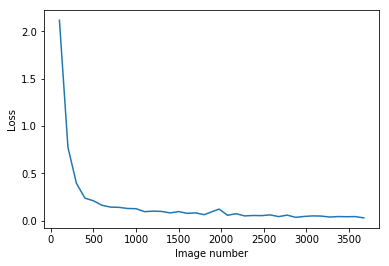

In [7]:
# Plot the loss over the training process
saved_losses = np.array(saved_losses)
plt.plot(saved_losses[:,0], saved_losses[:,1], label="Loss over epoch 1")
plt.xlabel("Image number")
plt.ylabel("Loss")
plt.show()

In [8]:
print(y_predict)

tensor([[-1.9315, -3.9664, -5.7940,  1.5558, -1.2009,  9.9752,  0.7597, -2.2048,
          1.1521,  1.5836],
        [-0.7017, -3.4590, -5.6536,  0.4656,  1.4072,  2.7152, -5.1720,  1.8198,
         -0.5484,  9.2614],
        [ 1.9471,  0.4971, 11.9395, -0.2864, -0.4228, -6.8389, -2.4030,  0.9977,
         -0.7995, -4.9375],
        [ 2.4931, -0.3464, 12.2885,  0.2342, -1.0659, -6.9585, -2.7586,  0.6327,
         -0.0961, -4.8113],
        [ 8.9945, -1.7981,  2.7746, -3.2586, -1.7240, -3.4609, -0.0716, -2.0427,
          0.0255, -0.0507],
        [-0.5095, -2.3330, -4.0832,  0.0713,  1.6444, -0.8145, -6.7216,  4.6037,
         -1.2347,  9.6452],
        [ 1.0333, -0.7069,  7.7020,  0.4527, -0.6622, -3.3344, -0.6075, -0.8624,
          0.9634, -4.2270],
        [-1.7257,  0.0381, -0.5388, -4.1480,  7.8296, -0.7845, -0.2302, -0.1566,
         -1.4247,  1.0556],
        [ 1.0096, -0.1305, -1.7069, -3.4939, -0.5148,  2.8759,  9.9688, -5.4851,
          1.4233, -4.3635],
        [-0.4636,  

In [9]:
print(y_real)

tensor([5, 9, 2, 2, 0, 9, 2, 4, 6, 7, 3, 1, 3, 6, 6, 2, 1, 2, 6, 0, 7, 8, 9, 2,
        9, 5, 1, 8, 3, 5, 6, 8], device='cuda:0')
